In [77]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 916, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 916 (delta 39), reused 33 (delta 29), pack-reused 860 (from 2)
Receiving objects: 100% (916/916), 28.17 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (523/523), done.
Filtering content: 100% (32/32), 1.75 GiB | 67.64 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [78]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [79]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
# from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [80]:
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01' # possibly change to 07-01 (option 1; dev data in end_year - 1 (e.g. 2023), test data in end_year (e.g. 2024) // option 2; dev data 1st half end_year, test data 2nd half end_year)
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.


In [81]:
import pandas as pd
import numpy as np
import os
import json
from typing import Dict, Any
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from transformers import AutoModelForCausalLM, AutoConfig
import random

# custom imports
from utils.visualization import plot_return_uncertainty, plot_comparison
from external.time_moe_repo.training_wrapper import train_time_moe
from backtesting.trading_strategy import trade
from backtesting.utils import calculate_return_uncertainty

## semi-custom
from external.time_moe_repo.time_moe.models.modeling_time_moe import TimeMoeForPrediction

In [113]:
### Time MoE Workflow Code ###
def execute_timemoe_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  burn_in: int = 30, # we remove the first 30 elements, because the largest window used for technical indicators is
  train_frac: float = 0.90,
  dev_frac: float = 0.05,   # remaining part is test
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 20,
  batch_size: int = 8,
  verbose: bool = True,
  load_finetuned = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl",
  pair_tup_str: str = "(?,?)", # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
  return_predicted_spread: bool = False
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  if not target_col in pairs_timeseries.columns:
    raise KeyError(f"pairs_timeseries must contain {target_col}")
  FLASH_ATTN = False

  # burn the first 30 elements
  pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_burned)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  # Standard version of the Time-MoE model can only take in univariate time series. Therefore, we will train only on the target_col
  # TODO: Convert to using multivariate again, a certain type of "multivariate" processing is possible according to the original time-moe paper, but not the version we would want to use. It is not possible to use many different features to enhance the prediction of the target column
  pairs_timeseries_burned_univariate = pairs_timeseries_burned[target_col]

  train = pairs_timeseries_burned_univariate[:train_size]
  dev   = pairs_timeseries_burned_univariate[train_size:train_size+dev_size] # aka validation
  test  = pairs_timeseries_burned_univariate[train_size+dev_size:]

  train_multivariate = pairs_timeseries_burned.iloc[:train_size]
  dev_multivariate = pairs_timeseries_burned.iloc[train_size:train_size+dev_size]
  test_multivariate = pairs_timeseries_burned.iloc[train_size+dev_size:]


  if verbose:
      print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

  DEVICE = "cpu" #  "cuda" if torch.cuda.is_available() else "cpu"

  def create_sequences(series):
      # series: pd.Series
      X_raw = torch.tensor(series.values, dtype=torch.float32)
      mean = X_raw.mean()
      std = X_raw.std()
      X_scaled = (X_raw - mean) / (std + 1e-8)
      return X_raw, X_scaled, X_raw, X_scaled, mean, std

  def create_sequences_rolling(series, look_back):
      X = []
      y = []
      for i in range(len(series) - look_back):
          seq = series.iloc[i:i+look_back].values
          target = series.iloc[i+look_back]
          X.append(seq)
          y.append(target) # TODO: check whether target really is Spread_Close, or whether it is S1_close or S2_close

      X = torch.tensor(X, dtype=torch.float32)
      y = torch.tensor(y, dtype=torch.float32)

      X = X.to(DEVICE)
      y = y.to(DEVICE)

      # normalize
      mean = X.mean(dim=-1, keepdim=True)
      std = X.std(dim=-1, keepdim=True)
      X_scaled = (X - mean) / (std + 1e-8)
      # For y, broadcast mean/std to match shape
      y_scaled = (y - mean.squeeze(-1)) / (std.squeeze(-1) + 1e-8)

      y = torch.tensor(y, dtype=torch.float32)
      y = y.to(DEVICE)
      return X, X_scaled, y, y_scaled, mean, std

  devX_raw, devX_scaled, devY_raw, devY_scaled, dev_mean, dev_std = create_sequences(dev)# , look_back)
  trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std = create_sequences(train) #, look_back)
  testX_raw, testX_scaled, testY_raw, testY_scaled, test_mean, test_std = create_sequences(test) #, look_back)

  ## use rolling sequences not for training, but still for inferencing dev and test ##
  devX_raw_rolling, devX_scaled_rolling, devY_raw_rolling, devY_scaled_rolling, dev_mean_rolling, dev_std_rolling = create_sequences_rolling(dev, look_back)
  testX_raw_rolling, testX_scaled_rolling, testY_raw_rolling, testY_scaled_rolling, test_mean_rolling, test_std_rolling = create_sequences_rolling(test, look_back)

  dev_ds_rolling = TensorDataset(devX_scaled_rolling, devY_scaled_rolling) # goal of TensorDataset class: loading and processing dataset lazily
  test_ds_rolling = TensorDataset(testX_scaled_rolling, testY_scaled_rolling)

  dev_loader_rolling = DataLoader(dev_ds_rolling, batch_size=batch_size, shuffle=False)
  test_loader_rolling = DataLoader(test_ds_rolling, batch_size=batch_size, shuffle=False)
  ## use rolling sequences not for training, but still for inferencing dev and test ##

  if verbose:
    print(f"devX_raw Shape: {devX_raw.shape}") # entire devX_raw has that shape before dataset and dev_loader logic

  dev_ds = TensorDataset(devX_scaled, devY_scaled) # goal of TensorDataset class: loading and processing dataset lazily
  train_ds = TensorDataset(trainX_scaled, trainY_scaled)
  test_ds = TensorDataset(testX_scaled, testY_scaled)

  dev_loader = DataLoader(dev_ds, batch_size=batch_size, shuffle=False) # DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc. (source; https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017)
  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

  if verbose:
    print(f"dev_loader tensor Shape: {next(iter(dev_loader))[0].shape}, with a total of {len(dev_loader)} batches") # a single tensor in dev_loader now has shape [batch_size, look_back] as expected

  if load_finetuned:
    ## Training (only train in the case where we actually also want to load finetuned :D )
    # save contents of trainX_scaled to jsonl using _get_filename {"sequence": [1.7994326779272853, 2.554412431241829,
    filename_jsonl = filename_base.replace(".pkl", ".jsonl")
    filepath_parent = os.path.join("data", "datasets")
    os.makedirs(filepath_parent, exist_ok=True)
    filepath_jsonl = os.path.join(filepath_parent, filename_jsonl)
    with open(filepath_jsonl, "w") as f: # Train scaled (improves results according to paper, and empirical tests have also shown this)
        json_line = json.dumps({"sequence": trainX_scaled.tolist()})
        f.write(json_line + "\n")

    train_time_moe(
        data_path=filepath_jsonl,
        dataloader_num_workers=2
    ) # after this, model is saved to logs/time_moe as model.safetensors (400+ MB)
    model_dir = "logs/time_moe"
    config = AutoConfig.from_pretrained(model_dir, trust_remote_code=True)
    model = TimeMoeForPrediction.from_pretrained(model_dir, config=config, torch_dtype=torch.float32)
    model.eval()
  else:
    model = AutoModelForCausalLM.from_pretrained(
        'Maple728/TimeMoE-50M',
        device_map=DEVICE,
        trust_remote_code=True,
    )
    if FLASH_ATTN: # if FLASH_ATTN, we assume the flash-attention module is installed, and adapt the model to use that
      model = AutoModelForCausalLM.from_pretrained('Maple728/TimeMoE-50M', device_map="auto", attn_implementation='flash_attention_2', trust_remote_code=True)

  prediction_length = 1 # TODO: rather than hardcoding prediction length, make a strategy where we can pick and choose different prediction lengths, and see what is affected by this (returns, std dev, ..)

  # forecast in batches from dev dataset
  all_predictions = []
  for i, batch in enumerate(test_loader_rolling):
    inputs = batch[0] # is devX_scaled, for now [1] will return error, later [1] will return devY_scaled :D

    yvals = batch[1]
    # means = batch[2]
    # stds = batch[3]

    output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
    normed_predictions = output[:, -prediction_length:]

    # from returned test_mean and test_std, slice the appropriate slices from the series
    input_size_current = inputs.size()
    batch_size_current = input_size_current[0]
    local_means = test_mean_rolling[batch_size*i : batch_size*i + batch_size_current]
    local_stds = test_std_rolling[batch_size*i : batch_size*i + batch_size_current]

    preds = normed_predictions * local_stds + local_means
    all_predictions.append(preds)

  # Concatenate all predictions
  predictions = torch.cat(all_predictions, dim=0)
  predictions = predictions.squeeze(-1)
  predictions = predictions.detach().numpy()

  # Also get dev/val predictions
  dev_predictions = []
  for i, batch in enumerate(dev_loader_rolling):
    inputs = batch[0]

    output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
    normed_predictions = output[:, -prediction_length:]
    input_size_current = inputs.size()
    batch_size_current = input_size_current[0]
    # get dev rather than test
    local_means = dev_mean_rolling[batch_size*i : batch_size*i + batch_size_current]
    local_stds = dev_std_rolling[batch_size*i : batch_size*i + batch_size_current]

    preds = normed_predictions * local_stds + local_means
    dev_predictions.append(preds)
  dev_predictions = torch.cat(dev_predictions, dim=0)
  dev_predictions = dev_predictions.squeeze(-1)
  dev_predictions = dev_predictions.detach().numpy()

  ## Trading
  test_s1_shortened = test_multivariate['S1_close'].iloc[look_back:]
  test_s2_shortened = test_multivariate['S2_close'].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
  test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
  forecast_test_shortened_series = pd.Series(predictions, index=test_index_shortened)
  gt_test_shortened_series = pd.Series(testY_raw.numpy()[look_back:], index=test_index_shortened)

  gt_returns = trade(
      S1 = test_s1_shortened,
      S2 = test_s2_shortened,
      spread = gt_test_shortened_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 1.0,
      clearing_threshold = 0.5
  )
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)

  ## Trading: Mean YoY
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)

  if load_finetuned:
    current_result_dir = filename_base.replace(".pkl", "_timemoe")
  else:
    current_result_dir = filename_base.replace(".pkl", "_timemoe_only_pretrained")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)

  ### Plotting #####
  # (no train/val loss plot, as Time-MoE repo did not support plots or even supplying val losses during training)
  train_val_loss_filename = None

  # 1. yoy returns
  yoy_returns_filename = plot_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, test_index_shortened, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

  # 2. predicted vs actual spread plot
  predicted_vs_actual_spread_filename = plot_comparison(gt_test_shortened_series, forecast_test_shortened_series, test_index_shortened, workflow_type="Time-MoE", pair_tup_str=pair_tup_str, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

  ### Plotting #####

  dev_mse = mean_squared_error(devY_raw.numpy()[look_back:], dev_predictions)
  test_mse = mean_squared_error(testY_raw.numpy()[look_back:], predictions)
  dev_variance = devY_raw.numpy()[look_back:].var()
  dev_nmse = dev_mse / dev_variance if dev_variance != 0 else float('inf')
  test_variance = testY_raw.numpy()[look_back:].var()
  test_nmse = test_mse / test_variance if test_variance != 0 else float('inf')

  # if return_predicted_spread:
  #   return forecast_test_shortened_series, test_nmse

  plot_filenames = {
      "yoy_returns": yoy_returns_filename,
      "predicted_vs_actual_spread": predicted_vs_actual_spread_filename,
      "train_val_loss": train_val_loss_filename
  }

  output: Dict[str, Any] = dict(
      val_mse=dev_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
      plot_filenames=plot_filenames
  )

  results_str = f"""
  Validation MSE: {output['val_mse']}
  Test MSE: {output['test_mse']}
  YOY Returns: {output['yoy_mean'] * 100:.2f}%
  YOY Std: +- {output['yoy_std'] * 100:.2f}%
  GT Yoy: {output['gt_yoy'] * 100:.2f}%
  Plot filepath parent dir: {output['result_parent_dir']}
  Plot filenames: {output['plot_filenames']}
  """

  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)
  return output

### Time MoE Workflow Code ###

In [114]:
verbose = True

def return_score(yoy_mean, gt_yoy):
  if gt_yoy == -1:
    return -1
  return round((1 + yoy_mean) / (1 + gt_yoy), 2)

def results_to_latex(results):
    headers = [
        "Pair",
        "Cointegration Score",
        "val MSE",
        "test MSE",
        "YoY Returns (std)",
        "\makecell{Theoretical Return\\\\Under Perfect\\\\Information}",
        "Return Score"
    ]
    # Latex column alignment: l for first col, c for others
    align_str = "l" + "c" * (len(headers)-1)
    # Begin building latex table string
    lines = []
    lines.append("\\begin{table}[h]")
    lines.append("\\centering")
    lines.append("\\small")
    lines.append("\\resizebox{\\textwidth}{!}{")
    lines.append("\\begin{tabular}{" + align_str + "}")
    lines.append("\\toprule")
    lines.append(" & ".join(headers) + " \\\\")
    lines.append("\\midrule")
    for idx, row in enumerate(results):
        row_out = []
        for col_idx, cell in enumerate(row):
            # Add numbering for pairs
            if col_idx == 0:
                cell = f"{idx+1}. {cell}"
            # Format cointegration score as scientific in latex
            elif col_idx == 1 and isinstance(cell, float):
                base, exp = f"{cell:.2e}".split("e")
                exp = int(exp)
                cell = f"${base}\\times 10^{{{exp}}}$"
            # Theoretical return: show as percent if small, otherwise keep as float
            elif col_idx == 5 and isinstance(cell, float):
                cell = f"{cell*100:.2f}\\%"
            # Format YoY Returns (std) as $a\% \pm b\%$
            elif col_idx == 4 and isinstance(cell, str) and "%" in cell:
                # Convert e.g. '-82.63% +- 30.20%' to latex: $-82.63\% \pm 30.20\%$
                cell = cell.replace("%", "\\%")
                cell = cell.replace("+-", "\\pm")
                cell = f"${cell}$"
            elif col_idx == 6 and isinstance(cell, float):
              cell = f"{cell:.2f}"
            # General float formatting
            elif isinstance(cell, float):
                cell = f"{cell:.5f}"
            # Replace % in any string field (needed for e.g. theoretical return if not float)
            elif isinstance(cell, str) and "%" in cell:
                cell = cell.replace("%", "\\%")
            row_out.append(cell)
        # Join and add row
        lines.append(" & ".join(str(x) for x in row_out) + " \\\\")
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("}")
    lines.append("\\caption{Model performance and return statistics for all tested pairs.}")
    lines.append("\\end{table}")
    return "\n".join(lines)

results_timemoe = []
num_results = min(len(pairs_data_filtered), 30)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']

    # model-specific call
    output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", load_finetuned=True, train_frac=train_frac, dev_frac=dev_frac)

    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_timemoe.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, val, test, yoy_str, gt_yoy, returns_score)

print(results_to_latex(results_timemoe))

Gathering [...]:   0%|          | 0/30 [00:00<?, ?it/s]

Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 11:59:06,089 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]


Step,Training Loss
1,0.033900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.10626725395998253
  Test MSE: 0.09116287942731739
  YOY Returns: 2.18%
  YOY Std: +- 0.59%
  GT Yoy: 3.81%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 11:59:18,884 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5295.84it/s]


Step,Training Loss
1,0.022500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.1937801260302217
  Test MSE: 0.10621608985009498
  YOY Returns: -98.69%
  YOY Std: +- 31.54%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 11:59:31,512 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3429.52it/s]


Step,Training Loss
1,0.023300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.09751477358330529
  Test MSE: 0.08337240490447187
  YOY Returns: -24.99%
  YOY Std: +- 52.26%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 11:59:44,435 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4843.31it/s]


Step,Training Loss
1,0.033000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.07641026966250265
  Test MSE: 0.07921181671967228
  YOY Returns: 1.72%
  YOY Std: +- 0.22%
  GT Yoy: 3.04%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 11:59:57,017 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1648.06it/s]


Step,Training Loss
1,0.012700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.05063662428789906
  Test MSE: 0.13566716285689795
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:00:09,764 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2589.08it/s]


Step,Training Loss
1,0.039200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.09513439406579613
  Test MSE: 0.18666523955772457
  YOY Returns: -83.67%
  YOY Std: +- 29.83%
  GT Yoy: -82.79%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:00:22,484 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2263.52it/s]


Step,Training Loss
1,0.021600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.15533859723864527
  Test MSE: 0.1032115497905974
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:00:35,574 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2310.91it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.019818524526759227
  Test MSE: 0.08246281929427704
  YOY Returns: 1886.02%
  YOY Std: +- 272.20%
  GT Yoy: 3284.18%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:00:48,107 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1949.03it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.028790002517396454
  Test MSE: 0.13848556936167286
  YOY Returns: 875.54%
  YOY Std: +- 179.98%
  GT Yoy: 1430.14%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:01:00,776 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2430.07it/s]


Step,Training Loss
1,0.015900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.03007267138427952
  Test MSE: 0.033910831863062194
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:01:13,485 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4284.27it/s]


Step,Training Loss
1,0.035300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.15599869910857037
  Test MSE: 0.0935193176449023
  YOY Returns: 6.08%
  YOY Std: +- 1.92%
  GT Yoy: 11.87%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:01:26,138 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 6141.00it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.01971901704756252
  Test MSE: 0.05615071132945307
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:01:39,371 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1892.74it/s]


Step,Training Loss
1,0.011900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.03779287321612313
  Test MSE: 0.06507784355602576
  YOY Returns: 346.16%
  YOY Std: +- 56.61%
  GT Yoy: 624.11%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:01:52,260 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1987.82it/s]


Step,Training Loss
1,0.011600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.01035975313465729
  Test MSE: 0.037261608566337805
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:02:05,053 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1973.79it/s]


Step,Training Loss
1,0.032200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.1426683055550414
  Test MSE: 0.09753421436222519
  YOY Returns: 1.79%
  YOY Std: +- 0.67%
  GT Yoy: 7.98%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:02:17,876 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1741.82it/s]


Step,Training Loss
1,0.034500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.09617759608884188
  Test MSE: 0.10584307224412685
  YOY Returns: -98.42%
  YOY Std: +- 17.96%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:02:30,317 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5489.93it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.012105938430496321
  Test MSE: 0.028487351441861864
  YOY Returns: 358.36%
  YOY Std: +- 62.30%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:02:43,308 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4447.83it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.02003745061665435
  Test MSE: 0.10682923062969744
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:02:55,364 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2565.32it/s]


Step,Training Loss
1,0.019500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.04686136214871459
  Test MSE: 0.07971714097909528
  YOY Returns: -74.29%
  YOY Std: +- 64.79%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:03:07,614 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3990.77it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.052856078485866397
  Test MSE: 0.10099860413324509
  YOY Returns: -72.37%
  YOY Std: +- 26.19%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:03:19,641 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1652.60it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.026786770750646404
  Test MSE: 0.017052680821372398
  YOY Returns: 790.41%
  YOY Std: +- 100.76%
  GT Yoy: 1300.99%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:03:31,692 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4443.12it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.03207660851752984
  Test MSE: 0.032312960313687696
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:03:43,885 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2332.76it/s]


Step,Training Loss
1,0.011300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.026451922878335477
  Test MSE: 0.08855463417031482
  YOY Returns: 2.82%
  YOY Std: +- 157.08%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:03:56,092 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5363.56it/s]


Step,Training Loss
1,0.022900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.10288123096412162
  Test MSE: 0.02525244054990689
  YOY Returns: 2.66%
  YOY Std: +- 2.08%
  GT Yoy: -51.19%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:04:08,165 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4006.02it/s]


Step,Training Loss
1,0.020700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.14618352957867622
  Test MSE: 0.09754297909762663
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:04:20,123 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 6223.00it/s]


Step,Training Loss
1,0.011600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.03299306013243578
  Test MSE: 0.028615144553742512
  YOY Returns: 832.57%
  YOY Std: +- 81.76%
  GT Yoy: 1153.60%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:04:32,075 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2480.37it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.1119943021377667
  Test MSE: 0.053035957130384795
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:04:44,069 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]


Step,Training Loss
1,0.022300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.07119109533124213
  Test MSE: 0.08850434466182297
  YOY Returns: -100.00%
  YOY Std: +- 0.00%
  GT Yoy: -100.00%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:04:56,061 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3942.02it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.06616518714585119
  Test MSE: 0.04496692573092982
  YOY Returns: 173.65%
  YOY Std: +- 20.22%
  GT Yoy: 230.21%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 12:05:08,151 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-113-f1a75c831bb2>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4177.59it/s]


Step,Training Loss
1,0.031500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

  Validation MSE: 0.038581393933685086
  Test MSE: 0.05688082648434032
  YOY Returns: 18.61%
  YOY Std: +- 3.53%
  GT Yoy: 38.44%
  Plot filepath parent dir: data/results
  Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.10627 & 0.09116 & $2.18\% \pm 0.59\%$ & 3.31\% & 0.99 \\
2. 

In [ ]:
def results_to_latex(results):
    headers = [
        "Pair",
        "Cointegration Score",
        "val MSE",
        "test MSE",
        "YoY Returns (std)",
        "\makecell{Theoretical Return\\\\Under Perfect\\\\Information}",
        "Return Score"
    ]
    # Latex column alignment: l for first col, c for others
    align_str = "l" + "c" * (len(headers)-1)
    # Begin building latex table string
    lines = []
    lines.append("\\begin{table}[h]")
    lines.append("\\centering")
    lines.append("\\small")
    lines.append("\\resizebox{\\textwidth}{!}{")
    lines.append("\\begin{tabular}{" + align_str + "}")
    lines.append("\\toprule")
    lines.append(" & ".join(headers) + " \\\\")
    lines.append("\\midrule")
    for idx, row in enumerate(results):
        row_out = []
        for col_idx, cell in enumerate(row):
            # Add numbering for pairs
            if col_idx == 0:
                cell = f"{idx+1}. {cell}"
            # Format cointegration score as scientific in latex
            elif col_idx == 1 and isinstance(cell, float):
                base, exp = f"{cell:.2e}".split("e")
                exp = int(exp)
                cell = f"${base}\\times 10^{{{exp}}}$"
            # Theoretical return: show as percent if small, otherwise keep as float
            elif col_idx == 5 and isinstance(cell, float):
                cell = f"{cell*100:.2f}\\%"
            # Format YoY Returns (std) as $a\% \pm b\%$
            elif col_idx == 4 and isinstance(cell, str) and "%" in cell:
                # Convert e.g. '-82.63% +- 30.20%' to latex: $-82.63\% \pm 30.20\%$
                cell = cell.replace("%", "\\%")
                cell = cell.replace("+-", "\\pm")
                cell = f"${cell}$"
            elif col_idx == 6 and isinstance(cell, float):
              cell = f"{cell:.2f}"
            # General float formatting
            elif isinstance(cell, float):
                cell = f"{cell:.5f}"
            # Replace % in any string field (needed for e.g. theoretical return if not float)
            elif isinstance(cell, str) and "%" in cell:
                cell = cell.replace("%", "\\%")
            row_out.append(cell)
        # Join and add row
        lines.append(" & ".join(str(x) for x in row_out) + " \\\\")
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("}")
    lines.append("\\caption{Model performance and return statistics for all tested pairs.}")
    lines.append("\\end{table}")
    return "\n".join(lines)



print(results_to_latex(results_timemoe))

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.10884 & 0.48144 & $-35.63\% \pm 47.84\%$ & 3.31\% & 0.62 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.19308 & 3.55606 & $-100.00\% \pm 0.00\%$ & -100.00\% & -1 \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.09622 & 1.65404 & $-90.42\% \pm 56.51\%$ & 11.61\% & 0.09 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.07504 & 0.25521 & $0.91\% \pm 0.68\%$ & 1.38\% & 1.00 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.05170 & 23.62582 & $-100.00\% \pm 0.00\%$ & -100.00\% & -1 \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.09776 & 1.08666 & $-17.40\% \pm 4.30\%$ & -63.21\% & 2.25 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.15543 & 4.47083 & $-100.00\% \pm 0.00\%$ & -100.00\% & -1 \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.

In [ ]:
all_train = []
# get all train variables
for i in range(len(pairs_data_filtered)):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  # burn the first 30 elements
  pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_burned)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  # Standard version of the Time-MoE model can only take in univariate time series. Therefore, we will train only on the target_col
  # TODO: Convert to using multivariate again, a certain type of "multivariate" processing is possible according to the original time-moe paper, but not the version we would want to use. It is not possible to use many different features to enhance the prediction of the target column
  pairs_timeseries_burned_univariate = pairs_timeseries_burned[target_col]

  train = pairs_timeseries_burned_univariate[:train_size]
  dev   = pairs_timeseries_burned_univariate[train_size:train_size+dev_size] # aka validation
  test  = pairs_timeseries_burned_univariate[train_size+dev_size:]
  all_train.append(train)

In [ ]:
len(all_train)

103

In [112]:
current_idx = 90
ticker_a, ticker_b = pairs_data_filtered[current_idx][0][0], pairs_data_filtered[current_idx][0][1]
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

### Time MoE Workflow Code Manual ###

pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = train_frac
dev_frac: float = dev_frac   # remaining part is test
seed: int = 3178749 # for reproducibility, my student number
look_back: int = 20
batch_size: int = 8
verbose: bool = True
load_finetuned = True
result_parent_dir: str = "data/results"
pair_tup_str=f"({ticker_a},{ticker_b})"
filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
# Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
return_predicted_spread: bool = False

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For GPU (if used)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")
FLASH_ATTN = False

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

# Standard version of the Time-MoE model can only take in univariate time series. Therefore, we will train only on the target_col
# TODO: Convert to using multivariate again, a certain type of "multivariate" processing is possible according to the original time-moe paper, but not the version we would want to use. It is not possible to use many different features to enhance the prediction of the target column
pairs_timeseries_burned_univariate = pairs_timeseries_burned[target_col]

train = pairs_timeseries_burned_univariate[:train_size]
dev   = pairs_timeseries_burned_univariate[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned_univariate[train_size+dev_size:]

train_multivariate = pairs_timeseries_burned.iloc[:train_size]
dev_multivariate = pairs_timeseries_burned.iloc[train_size:train_size+dev_size]
test_multivariate = pairs_timeseries_burned.iloc[train_size+dev_size:]


if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

DEVICE = "cpu" #  "cuda" if torch.cuda.is_available() else "cpu"

def create_sequences(series):
    # series: pd.Series
    X_raw = torch.tensor(series.values, dtype=torch.float32)
    mean = X_raw.mean()
    std = X_raw.std()
    X_scaled = (X_raw - mean) / (std + 1e-8)
    return X_raw, X_scaled, X_raw, X_scaled, mean, std

def create_sequences_rolling(series, look_back):
    X = []
    y = []
    for i in range(len(series) - look_back):
        seq = series.iloc[i:i+look_back].values
        target = series.iloc[i+look_back]
        X.append(seq)
        y.append(target) # TODO: check whether target really is Spread_Close, or whether it is S1_close or S2_close

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    X = X.to(DEVICE)
    y = y.to(DEVICE)

    # normalize
    mean = X.mean(dim=-1, keepdim=True)
    std = X.std(dim=-1, keepdim=True)
    X_scaled = (X - mean) / (std + 1e-8)
    # For y, broadcast mean/std to match shape
    y_scaled = (y - mean.squeeze(-1)) / (std.squeeze(-1) + 1e-8)

    y = torch.tensor(y, dtype=torch.float32)
    y = y.to(DEVICE)
    return X, X_scaled, y, y_scaled, mean, std

devX_raw, devX_scaled, devY_raw, devY_scaled, dev_mean, dev_std = create_sequences(dev)# , look_back)
trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std = create_sequences(train) #, look_back)
testX_raw, testX_scaled, testY_raw, testY_scaled, test_mean, test_std = create_sequences(test) #, look_back)

## use rolling sequences not for training, but still for inferencing dev and test ##
devX_raw_rolling, devX_scaled_rolling, devY_raw_rolling, devY_scaled_rolling, dev_mean_rolling, dev_std_rolling = create_sequences_rolling(dev, look_back)
testX_raw_rolling, testX_scaled_rolling, testY_raw_rolling, testY_scaled_rolling, test_mean_rolling, test_std_rolling = create_sequences_rolling(test, look_back)

dev_ds_rolling = TensorDataset(devX_scaled_rolling, devY_scaled_rolling) # goal of TensorDataset class: loading and processing dataset lazily
test_ds_rolling = TensorDataset(testX_scaled_rolling, testY_scaled_rolling)

dev_loader_rolling = DataLoader(dev_ds_rolling, batch_size=batch_size, shuffle=False)
test_loader_rolling = DataLoader(test_ds_rolling, batch_size=batch_size, shuffle=False)
## use rolling sequences not for training, but still for inferencing dev and test ##

if verbose:
  print(f"devX_raw Shape: {devX_raw.shape}") # entire devX_raw has that shape before dataset and dev_loader logic

dev_ds = TensorDataset(devX_scaled, devY_scaled) # goal of TensorDataset class: loading and processing dataset lazily
train_ds = TensorDataset(trainX_scaled, trainY_scaled)
test_ds = TensorDataset(testX_scaled, testY_scaled)

dev_loader = DataLoader(dev_ds, batch_size=batch_size, shuffle=False) # DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc. (source; https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

if verbose:
  print(f"dev_loader tensor Shape: {next(iter(dev_loader))[0].shape}, with a total of {len(dev_loader)} batches") # a single tensor in dev_loader now has shape [batch_size, look_back] as expected

if load_finetuned:
  ## Training (only train in the case where we actually also want to load finetuned :D )
  # save contents of trainX_scaled to jsonl using _get_filename {"sequence": [1.7994326779272853, 2.554412431241829,
  filename_jsonl = filename_base.replace(".pkl", ".jsonl")
  filepath_parent = os.path.join("data", "datasets")
  os.makedirs(filepath_parent, exist_ok=True)
  filepath_jsonl = os.path.join(filepath_parent, filename_jsonl)
  # first method: try to train it on unnormalized sequence
  # with open(filepath_jsonl, "w") as f: # Train unscaled
  #     json_line = json.dumps({"sequence": train.to_list()})
  #     f.write(json_line + "\n")
  with open(filepath_jsonl, "w") as f: # Train scaled
      json_line = json.dumps({"sequence": trainX_scaled.tolist()})
      f.write(json_line + "\n")

  train_time_moe(
      data_path=filepath_jsonl,
      dataloader_num_workers=2
  ) # after this, model is saved to logs/time_moe as model.safetensors (400+ MB)
  model_dir = "logs/time_moe"
  config = AutoConfig.from_pretrained(model_dir, trust_remote_code=True)
  model = TimeMoeForPrediction.from_pretrained(model_dir, config=config, torch_dtype=torch.float32)
  model.eval()
else:
  model = AutoModelForCausalLM.from_pretrained(
      'Maple728/TimeMoE-50M',
      device_map=DEVICE,
      trust_remote_code=True,
  )
  if FLASH_ATTN: # if FLASH_ATTN, we assume the flash-attention module is installed, and adapt the model to use that
    model = AutoModelForCausalLM.from_pretrained('Maple728/TimeMoE-50M', device_map="auto", attn_implementation='flash_attention_2', trust_remote_code=True)

prediction_length = 1 # TODO: rather than hardcoding prediction length, make a strategy where we can pick and choose different prediction lengths, and see what is affected by this (returns, std dev, ..)

# forecast in batches from dev dataset
all_predictions = []
all_normalized_predictions = []
for i, batch in enumerate(test_loader_rolling):
  inputs = batch[0] # is devX_scaled, for now [1] will return error, later [1] will return devY_scaled :D

  yvals = batch[1]
  # means = batch[2]
  # stds = batch[3]

  output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
  normed_predictions = output[:, -prediction_length:]

  # from returned test_mean and test_std, slice the appropriate slices from the series
  input_size_current = inputs.size()
  batch_size_current = input_size_current[0]
  local_means = test_mean_rolling[batch_size*i : batch_size*i + batch_size_current]
  local_stds = test_std_rolling[batch_size*i : batch_size*i + batch_size_current]

  preds = normed_predictions * local_stds + local_means
  all_predictions.append(preds)
  all_normalized_predictions.append(normed_predictions)


# Concatenate all predictions
predictions = torch.cat(all_predictions, dim=0)
predictions = predictions.squeeze(-1)
predictions = predictions.detach().numpy()

all_normalized_predictions = torch.cat(all_normalized_predictions, dim=0)
all_normalized_predictions = all_normalized_predictions.squeeze(-1)
all_normalized_predictions = all_normalized_predictions.detach().numpy()

# Also get dev/val predictions
dev_predictions = []
dev_normalized_predictions = []
for i, batch in enumerate(dev_loader_rolling):
  inputs = batch[0]

  output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
  normed_predictions = output[:, -prediction_length:]
  input_size_current = inputs.size()
  batch_size_current = input_size_current[0]
  # get dev rather than test
  local_means = dev_mean_rolling[batch_size*i : batch_size*i + batch_size_current]
  local_stds = dev_std_rolling[batch_size*i : batch_size*i + batch_size_current]

  preds = normed_predictions * local_stds + local_means
  dev_predictions.append(preds)
  dev_normalized_predictions.append(normed_predictions)
dev_predictions = torch.cat(dev_predictions, dim=0)
dev_predictions = dev_predictions.squeeze(-1)
dev_predictions = dev_predictions.detach().numpy()

dev_normalized_predictions = torch.cat(dev_normalized_predictions, dim=0)
dev_normalized_predictions = dev_normalized_predictions.squeeze(-1)
dev_normalized_predictions = dev_normalized_predictions.detach().numpy()

## Trading
test_s1_shortened = test_multivariate['S1_close'].iloc[look_back:]
test_s2_shortened = test_multivariate['S2_close'].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
forecast_test_shortened_series = pd.Series(predictions, index=test_index_shortened)
gt_test_shortened_series = pd.Series(testY_raw.numpy()[look_back:], index=test_index_shortened)

gt_returns = trade(
    S1 = test_s1_shortened,
    S2 = test_s2_shortened,
    spread = gt_test_shortened_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 1.0,
    clearing_threshold = 0.5
)
gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)

## Trading: Mean YoY
min_position = 2.00
max_position = 4.00
min_clearing = 0.30
max_clearing = 0.70
position_thresholds = np.linspace(min_position, max_position, num=10)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)

if load_finetuned:
  current_result_dir = filename_base.replace(".pkl", "_timemoe")
else:
  current_result_dir = filename_base.replace(".pkl", "_timemoe_only_pretrained")
result_dir = os.path.join(result_parent_dir, current_result_dir)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

### Plotting #####
# (no train/val loss plot, as Time-MoE repo did not support plots or even supplying val losses during training)
train_val_loss_filename = None

# 1. yoy returns
yoy_returns_filename = plot_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, test_index_shortened, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

# 2. predicted vs actual spread plot
predicted_vs_actual_spread_filename = plot_comparison(gt_test_shortened_series, forecast_test_shortened_series, test_index_shortened, workflow_type="Time-MoE", pair_tup_str=pair_tup_str, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

### Plotting #####

dev_mse = mean_squared_error(devY_raw.numpy()[look_back:], dev_predictions)
test_mse = mean_squared_error(testY_raw.numpy()[look_back:], predictions)
dev_variance = devY_raw.numpy()[look_back:].var()
dev_nmse = dev_mse / dev_variance if dev_variance != 0 else float('inf')
test_variance = testY_raw.numpy()[look_back:].var()
test_nmse = test_mse / test_variance if test_variance != 0 else float('inf')

# if return_predicted_spread:
#   return forecast_test_shortened_series, test_nmse

plot_filenames = {
    "yoy_returns": yoy_returns_filename,
    "predicted_vs_actual_spread": predicted_vs_actual_spread_filename,
    "train_val_loss": train_val_loss_filename
}

output: Dict[str, Any] = dict(
    val_mse=dev_nmse,
    test_mse=test_nmse,
    yoy_mean=yoy_mean,
    yoy_std=yoy_std,
    gt_yoy=gt_yoy,
    result_parent_dir=result_parent_dir,
    plot_filenames=plot_filenames
)
results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
Plot filenames: {output['plot_filenames']}
"""

with open(os.path.join(result_dir, "results.txt"), "w") as f:
    f.write(results_str)
if verbose:
  print(results_str)


### Time MoE Workflow Code Manual ###

## Calculating MSE when training unscaled
# forecast_test_shortened_series_raw_output = pd.Series(all_normalized_predictions, index=test_index_shortened)
# gt_test_shortened_series_unscaled = pd.Series(testY_raw.numpy(), index=test_index_shortened)
# test_mse_correct = mean_squared_error(gt_test_shortened_series_unscaled, forecast_test_shortened_series_raw_output)
# test_var = gt_test_shortened_series_unscaled.var(ddof=0)
# test_nmse_correct = test_mse_correct / test_var if test_var != 0 else float('inf')

# dev_multivariate = pairs_timeseries_burned.iloc[train_size:train_size+dev_size]
# dev_index_shortened = dev_multivariate.index[look_back:]

# forecast_dev_shortened_series_raw_output = pd.Series(dev_normalized_predictions, index=dev_index_shortened)
# gt_dev_shortened_series_unscaled = pd.Series(devY_raw.numpy(), index=dev_index_shortened)
# dev_mse_correct = mean_squared_error(gt_dev_shortened_series_unscaled, forecast_dev_shortened_series_raw_output)
# dev_var = gt_dev_shortened_series_unscaled.var(ddof=0)
# dev_nmse_correct = dev_mse_correct / dev_var if dev_var != 0 else float('inf')

# print(f"Dev MSE correct: {dev_mse_correct}\nTest MSE correct: {test_mse_correct}")
# print(f"Dev NMSE correct: {dev_nmse_correct}\nTest NMSE correct: {test_nmse_correct}")

Split sizes — train: 3747, dev: 249, test: 251
devX_raw Shape: torch.Size([249])
dev_loader tensor Shape: torch.Size([8]), with a total of 32 batches
2025-05-29 11:53:14,489 - log_util.py[pid:2194;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


<ipython-input-112-b0e1353a4cd9>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3339.41it/s]


Step,Training Loss
1,0.013700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_01_01_2024_12_31_4416cb3b_timemoe/data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.21539771090894494
Test MSE: 0.11442924472711585
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_01_01_2024_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_01_01_2024_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}

Dev MSE correct (using scaled training): 1.5327849388122559
Test MSE descaled (using scaled training): 2.0297510623931885
Dev NMSE correct (using scaled training): 0.2153976964754666
Test NMSE descaled (using scaled training): 0.11442920781384898


Dev MSE correct (using scaled training): 0.0643489882349968
Test MSE descaled (using scaled training): 0.01488699670881033
Dev NMSE correct (using scaled training): 0.10626723303971626
Test NMSE descaled (using scaled training): 0.09116287942731739


59.09696191776058 0.21540275561750716


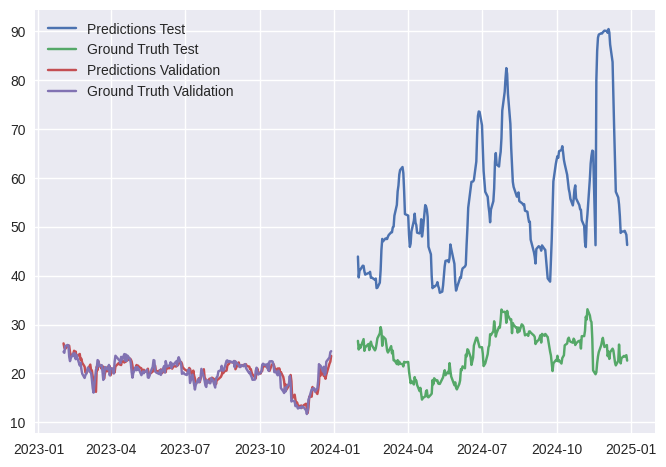

In [86]:
plt.plot(forecast_test_shortened_series, label="Predictions Test")
plt.plot(pd.Series(testY_raw.numpy(), index=test_index_shortened), label="Ground Truth Test")
test_mse = mean_squared_error(forecast_test_shortened_series, gt_test_shortened_series)
# Make sure to set ddof=0 for population variance
test_variance = gt_test_shortened_series.var(ddof=0)
test_nmse = test_mse / test_variance if test_variance != 0 else float('inf')

dev_index_shortened = dev_multivariate.index[look_back:]
gt_dev_shortened_series = pd.Series(devY_raw.numpy(), index=dev_index_shortened)
forecast_dev_shortened_series = pd.Series(dev_predictions, index=dev_index_shortened)

plt.plot(forecast_dev_shortened_series, label="Predictions Validation")
plt.plot(gt_dev_shortened_series, label="Ground Truth Validation")
dev_mse = mean_squared_error(forecast_dev_shortened_series, gt_dev_shortened_series)
# Make sure to set ddof=0 for population variance
dev_variance = gt_dev_shortened_series.var(ddof=0)
dev_nmse = dev_mse / dev_variance if dev_variance != 0 else float('inf')
print(test_nmse, dev_nmse)

train_index_shortened = train_multivariate.index[look_back:]
gt_train_series = pd.Series(trainY_raw.numpy(), index=train_index_shortened)
plt.plot(gt_train_series, label="Train timeseries")
plt.legend()

In [43]:
# sanity check: MSE of unscaled test and dev
# all_normalized_predictions

# dev/validation
dev_index_shortened = dev_multivariate.index[look_back:]
gt_dev_shortened_series_normalized = pd.Series(devY_scaled.numpy(), index=dev_index_shortened)
forecast_dev_shortened_series_normalized = pd.Series(dev_normalized_predictions, index=dev_index_shortened)
dev_mse_normalized = mean_squared_error(forecast_dev_shortened_series_normalized, gt_dev_shortened_series_normalized)

# test
test_index_shortened = test_multivariate.index[look_back:]
gt_test_shortened_series_normalized = pd.Series(testY_scaled.numpy(), index=test_index_shortened)
forecast_test_shortened_series_normalized = pd.Series(all_normalized_predictions, index=test_index_shortened)
test_mse_normalized = mean_squared_error(forecast_test_shortened_series_normalized, gt_test_shortened_series_normalized)

print(dev_mse_normalized, test_mse_normalized)

0.8216304779052734 194.31967163085938


In [45]:
print("==== SHAPES ====")
print(f"train: {train.shape}, dev: {dev.shape}, test: {test.shape}")
print(f"train_multivariate: {train_multivariate.shape}, dev_multivariate: {dev_multivariate.shape}, test_multivariate: {test_multivariate.shape}")
print(f"devX_raw: {devX_raw.shape}, devX_scaled: {devX_scaled.shape}, devY_raw: {devY_raw.shape}, devY_scaled: {devY_scaled.shape}")
print(f"testX_raw: {testX_raw.shape}, testX_scaled: {testX_scaled.shape}, testY_raw: {testY_raw.shape}, testY_scaled: {testY_scaled.shape}")
print(f"predictions: {predictions.shape}, all_normalized_predictions: {all_normalized_predictions.shape}")
print(f"dev_predictions: {dev_predictions.shape}, dev_normalized_predictions: {dev_normalized_predictions.shape}")

print("\n==== INDICES ====")
print(f"train index: {train.index[0]} to {train.index[-1]}")
print(f"dev index: {dev.index[0]} to {dev.index[-1]}")
print(f"test index: {test.index[0]} to {test.index[-1]}")
print(f"test_multivariate['S1_close'] index: {test_multivariate['S1_close'].index[0]} to {test_multivariate['S1_close'].index[-1]}")
print(f"test_index_shortened: {test_index_shortened[0]} to {test_index_shortened[-1]}")
print(f"dev_index_shortened: {dev_index_shortened[0]} to {dev_index_shortened[-1]}")

print("\n==== SAMPLE VALUES ====")
print("First 5 devY_raw:", devY_raw[:5])
print("First 5 devY_scaled:", devY_scaled[:5])
print("First 5 testY_raw:", testY_raw[:5])
print("First 5 testY_scaled:", testY_scaled[:5])
print("First 5 predictions:", predictions[:5])
print("First 5 dev_predictions:", dev_predictions[:5])

print("\n==== NORMALIZATION CHECKS ====")
print(f"dev_mean shape: {dev_mean.shape}, dev_std shape: {dev_std.shape}")
print(f"test_mean shape: {test_mean.shape}, test_std shape: {test_std.shape}")
print("First 5 dev_mean:", dev_mean[:5])
print("First 5 dev_std:", dev_std[:5])
print("First 5 test_mean:", test_mean[:5])
print("First 5 test_std:", test_std[:5])

print("\n==== MSEs for sanity check ====")
print(f"Denormalized Test MSE: {test_mse}")
print(f"Denormalized Dev MSE: {dev_mse}")
print(f"Normalized Test MSE: {test_mse_normalized}")
print(f"Normalized Dev MSE: {dev_mse_normalized}")
print(f"Test variance: {test_variance}")
print(f"Dev variance: {dev_variance}")

print("\n==== MISC ====")
print(f"look_back: {look_back}")
print(f"batch_size: {batch_size}")
print(f"burn_in: {burn_in}")
print(f"train_size: {train_size}, dev_size: {dev_size}, test_size: {test_size}")
print(f"Total pairs_timeseries_burned length: {len(pairs_timeseries_burned)}")


==== SHAPES ====
train: (3747,), dev: (249,), test: (251,)
train_multivariate: (3747, 34), dev_multivariate: (249, 34), test_multivariate: (251, 34)
devX_raw: torch.Size([229, 20]), devX_scaled: torch.Size([229, 20]), devY_raw: torch.Size([229]), devY_scaled: torch.Size([229])
testX_raw: torch.Size([231, 20]), testX_scaled: torch.Size([231, 20]), testY_raw: torch.Size([231]), testY_scaled: torch.Size([231])
predictions: (231,), all_normalized_predictions: (231,)
dev_predictions: (229,), dev_normalized_predictions: (229,)

==== INDICES ====
train index: 2008-02-14 00:00:00 to 2022-12-30 00:00:00
dev index: 2023-01-03 00:00:00 to 2023-12-28 00:00:00
test index: 2023-12-29 00:00:00 to 2024-12-27 00:00:00
test_multivariate['S1_close'] index: 2023-12-29 00:00:00 to 2024-12-27 00:00:00
test_index_shortened: 2024-01-30 00:00:00 to 2024-12-27 00:00:00
dev_index_shortened: 2023-02-01 00:00:00 to 2023-12-28 00:00:00

==== SAMPLE VALUES ====
First 5 devY_raw: tensor([-14.6934, -14.4607, -14.5346,

0.026786201130362525

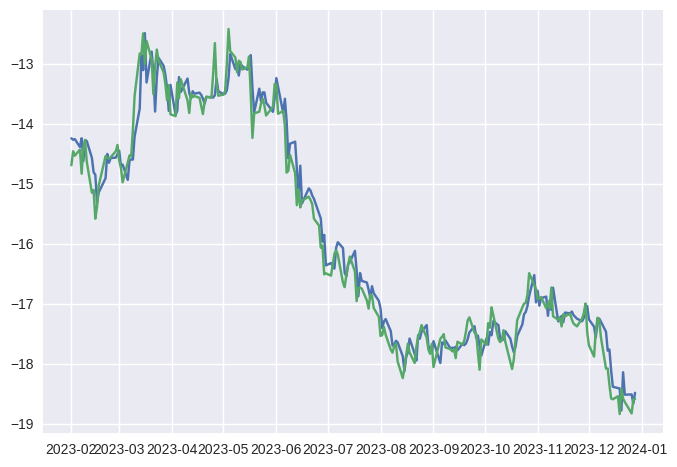

In [ ]:
first_param = next(model.parameters()).data
print("First 10 weights of first param:", first_param.flatten()[:10].cpu().numpy())
# pairs_timeseries_df of latest element [-1] gave the weight: [ 0.04013866 -0.04795108  0.03871797 -0.03122762 -0.05527523 -0.03969453 0.03159382 -0.04067107 -0.0423359  -0.05141316]
# pairs_timeseries_df of element [-2] gave the weights: [ 0.04013865 -0.04795108  0.03891797 -0.03122762 -0.05527523 -0.03969454 0.03159382 -0.04067108 -0.04213591 -0.05141316]
# Although we are unsure if this is supposed to change, we can definitely check whether it changes when we change the output_path
# pairs_timeseries_df of element [-2] AFTER modifying output path gave the weights [ 0.04013865 -0.04795108  0.03891797 -0.03122762 -0.05527523 -0.03969454 0.03159382 -0.04067108 -0.04213591 -0.05141316]
# the same weights,


In [ ]:
import hashlib

def file_hash(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

model_new_dir = "logs/time_moe/test/model.safetensors"
model_old_dir = "logs/time_moe/model.safetensors"

hash_new = file_hash(model_new_dir)
hash_old = file_hash(model_old_dir)

print("New model hash:", hash_new)
print("Old model hash:", hash_old)

if hash_new == hash_old:
    print("The files are identical.")
else:
    print("The files are different.")

In [ ]:
# goal: first 10 results more than one positive yoy return

print("Hello, World!")
model_new_dir = "logs/time_moe/test/model.safetensors"
model_old_dir = "logs/time_moe/model.safetensors"

In [ ]:
def return_score(yoy_mean, gt_yoy):
  if gt_yoy == -1:
    return -1
  return round((1 + yoy_mean) / (1 + gt_yoy), 2)

def results_to_ascii_table(results):
    # Define column headers
    headers = [
        "Pair",
        "Cointegration Score",
        "val MSE",
        "test MSE",
        "YoY Returns (std)",
        "Theoretical Return Under Perfect Information",
        "Return Score"
    ]
    # Calculate the max width for each column
    cols = list(zip(*results))
    col_widths = [
        max(len(str(h)), *(len(str(cell)) for cell in col))
        for h, col in zip(headers, cols)
    ]
    # Helper to create a line separator
    def make_sep(char="+", pad="-"):
        return char + char.join(pad * (w + 2) for w in col_widths) + char

    def format_row(row, col_widths, row_idx=None, number_pair=False):
        formatted_cells = []
        for col_idx, (cell, w) in enumerate(zip(row, col_widths)):
            # Add numbering if required and it's the first column (Pair)
            if number_pair and col_idx == 0 and row_idx is not None:
                cell = f"{row_idx + 1}. {cell}"
            if col_idx == 1 and isinstance(cell, float):
                # format cointegration score in the format "x.x*10^x"
                cell = f"{cell:.2e}".replace("e","*10^")
            if col_idx == 5 and isinstance(cell, float):
                cell = f"{cell*100:.2f}%"
            if isinstance(cell, float):
                cell = f"{cell:.5f}"
            formatted_cells.append(f"{str(cell):<{w}}")
        return "| " + " | ".join(formatted_cells) + " |"

    # Build table
    lines = []
    lines.append(make_sep())
    lines.append(format_row(headers, col_widths))
    lines.append(make_sep(char="+", pad="="))
    for idx, row in enumerate(results):
        lines.append(format_row(row, col_widths, row_idx=idx, number_pair=True))
        lines.append(make_sep())
    return "\n".join(lines)
